In [25]:
import numpy as np
import pandas as pd
import os

In [12]:
pip install tensorflow

In [48]:
import cv2
import os
import numpy as np
from tensorflow.keras import utils, layers, models, optimizers
from keras.utils import plot_model

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.layers import  Dense, Dropout, Activation, Flatten

import seaborn as sn
import tensorflow as tf

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from tensorflow.keras.models import Sequential

# from keras.preprocessing.image import ImageDataGenerator
# # from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
train_path="/content/drive/MyDrive/images/train"
val_path="/content/drive/MyDrive/images/validation"
train_data_list= os.listdir(train_path)
val_data_list= os.listdir(val_path)

In [16]:
train_data_list

['surprise', 'neutral', 'sad', 'happy', 'angry', 'disgust', 'fear']

In [17]:
import cv2
import os
import numpy as np

def Data_prepare(data_list, path):
    img_data = []
    for dataset in data_list:
        img_list = os.listdir(os.path.join(path, dataset))
        subfolder_path = os.path.join(path, dataset)
        num_items = len([item for item in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, item))])
        print(f"Loading The images from the folder {dataset}, {num_items} images")
        for img in img_list:
            input_img = cv2.imread(os.path.join(subfolder_path, img))
            input_img_resized = cv2.resize(input_img, (96, 96))
            img_data.append(input_img_resized)
    data = np.array(img_data)
    data = data.astype("float32")
    data = data / 255.0
    return data


In [23]:
train_data=Data_prepare(train_data_list,train_path)


Loading The images from the folder surprise, 120 images
Loading The images from the folder neutral, 104 images
Loading The images from the folder sad, 378 images
Loading The images from the folder happy, 96 images
Loading The images from the folder angry, 24 images
Loading The images from the folder disgust, 42 images
Loading The images from the folder fear, 48 images


In [ ]:
val_data=Data_prepare(val_data_list,val_path)


Loading The images from the folder sad, 1139 images
Loading The images from the folder fear, 185 images
Loading The images from the folder surprise, 797 images
Loading The images from the folder disgust, 0 images
Loading The images from the folder neutral, 1216 images
Loading The images from the folder angry, 0 images
Loading The images from the folder happy, 1825 images


In [26]:
num_classes= 7
num_train_samples=train_data.shape[0]
num_val_samples=val_data.shape[0]
print(f"Train data shape :{train_data.shape}")
print(f"Validation data shape :{val_data.shape}")

Train data shape :(812, 96, 96, 3)
Validation data shape :(5162, 96, 96, 3)


In [27]:
# One hot vector -> Labels
train_labels=np.ones((num_train_samples,),dtype="int64")
train_labels[0:3205] = 0 # -> Surprise
train_labels[3205:7308] = 1 # -> Fear
train_labels[7308:11301] = 2 # -> Angry
train_labels[11301:16283] = 3 # -> Netural
train_labels[16283:21221] = 4 # -> Sad
train_labels[21221:21657] = 5 # -> Disgust
train_labels[21657:28821] = 6 # -> Happy
img_train_labels=utils.to_categorical(train_labels,num_classes)


val_labels=np.ones((num_val_samples,),dtype="int64")
val_labels[0:797] = 0 # -> Surprise
val_labels[797:1815] = 1 # -> Fear
val_labels[1815:2775] = 2 # -> Angry
val_labels[2775:3991] = 3 # -> Netural
val_labels[3991:5130] = 4 # -> Sad
val_labels[5130:5214] = 5 # -> Disgust
val_labels[5214:7066] = 6 # -> Happy
img_val_labels=utils.to_categorical(val_labels,num_classes)

In [30]:
index = 811

In [31]:
X_train,Y_train=shuffle(train_data,img_train_labels,random_state=5)
X_test,Y_test=shuffle(val_data,img_val_labels,random_state=5)

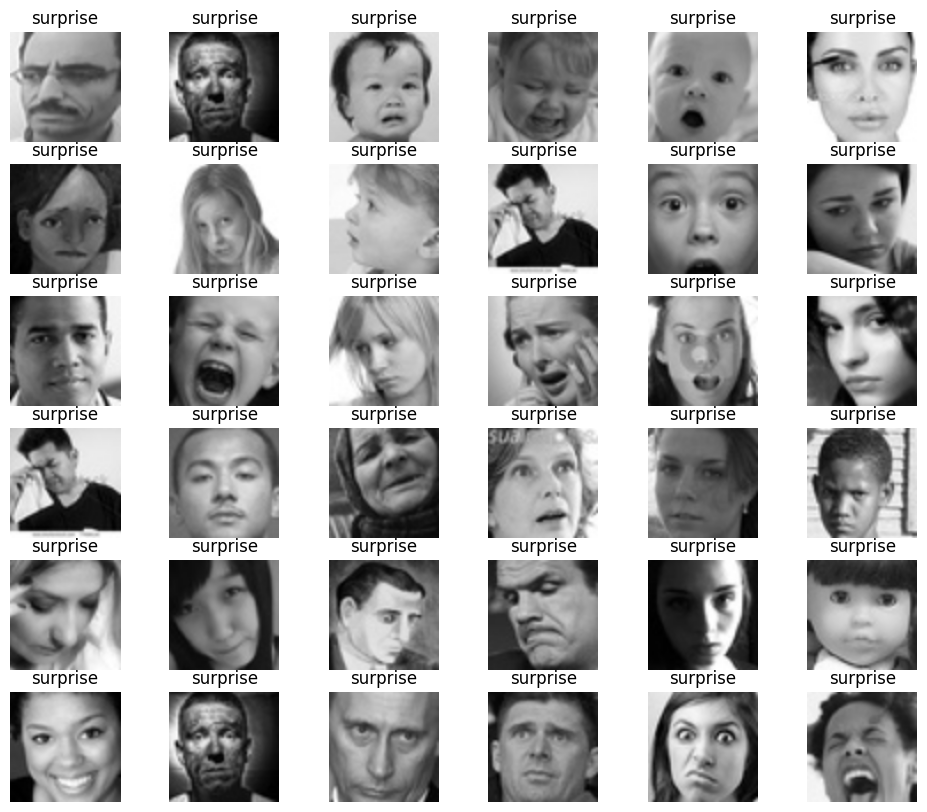

In [32]:
plt.figure(figsize=(12, 10))
for i, j in enumerate(list(np.random.randint(0, len(train_data), 36))):  # index,item
    plt.subplot(6, 6, i+1)
    plt.imshow(train_data[j])
    plt.axis("off")
    plt.title(train_data_list[list(Y_train[j].astype(int)).index(1)] if Y_train is not None else "Label")
plt.show()


In [50]:
# Define CNN architecture
def create_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(64, activation='relu')
    ])

# Combine CNN with RNN
def create_cnn_rnn():
    cnn = create_cnn()
    return Sequential([
        TimeDistributed(cnn, input_shape=(5, 64, 64, 1)),
        LSTM(64, return_sequences=True),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

In [41]:
# Resizing and converting to grayscale
train_data_resized = tf.image.rgb_to_grayscale(tf.image.resize(train_data, (64, 64)))

In [42]:
# Forming sequences
def form_sequences(data, sequence_length=5):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

train_data_sequences = form_sequences(train_data_resized)

In [51]:
# Model setup and training
model = create_cnn_rnn()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data_sequences, Y_train[:len(train_data_sequences)], epochs=10)

Epoch 1/10
26/26 [==============================] - 34s 1s/step - loss: 0.6692 - accuracy: 0.9604
Epoch 2/10
26/26 [==============================] - 27s 1s/step - loss: 0.0131 - accuracy: 1.0000
Epoch 3/10
26/26 [==============================] - 34s 1s/step - loss: 0.0031 - accuracy: 1.0000
Epoch 4/10
26/26 [==============================] - 28s 1s/step - loss: 0.0020 - accuracy: 1.0000
Epoch 5/10
26/26 [==============================] - 28s 1s/step - loss: 0.0014 - accuracy: 1.0000
Epoch 6/10
26/26 [==============================] - 28s 1s/step - loss: 0.0011 - accuracy: 1.0000
Epoch 7/10
26/26 [==============================] - 33s 1s/step - loss: 8.4880e-04 - accuracy: 1.0000
Epoch 8/10
26/26 [==============================] - 29s 1s/step - loss: 6.8872e-04 - accuracy: 1.0000
Epoch 9/10
26/26 [==============================] - 29s 1s/step - loss: 5.7244e-04 - accuracy: 1.0000
Epoch 10/10
26/26 [==============================] - 29s 1s/step - loss: 4.8458e-04 - accuracy: 1.0000


162/162 [==============================] - 63s 390ms/step


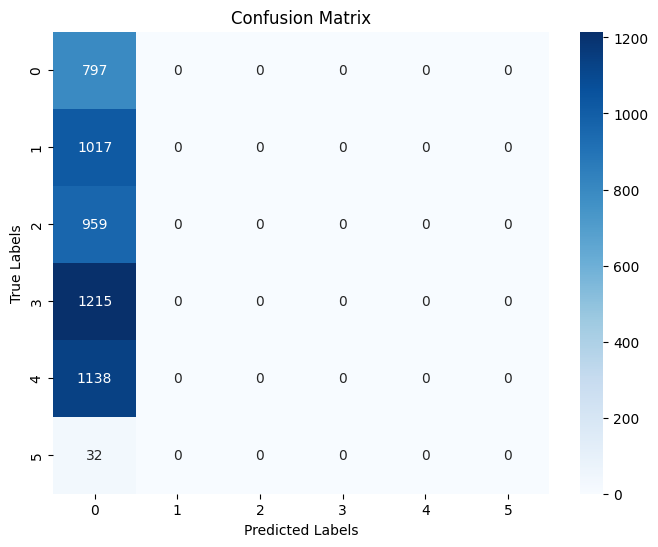

In [57]:
# Generating predictions for test data
test_data_resized = tf.image.rgb_to_grayscale(tf.image.resize(val_data, (64, 64)))
test_data_sequences = form_sequences(test_data_resized)
predictions = model.predict(test_data_sequences)

In [58]:
# Convert predictions to labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(Y_test[:len(test_data_sequences)], axis=1)

In [59]:
# Creating confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)

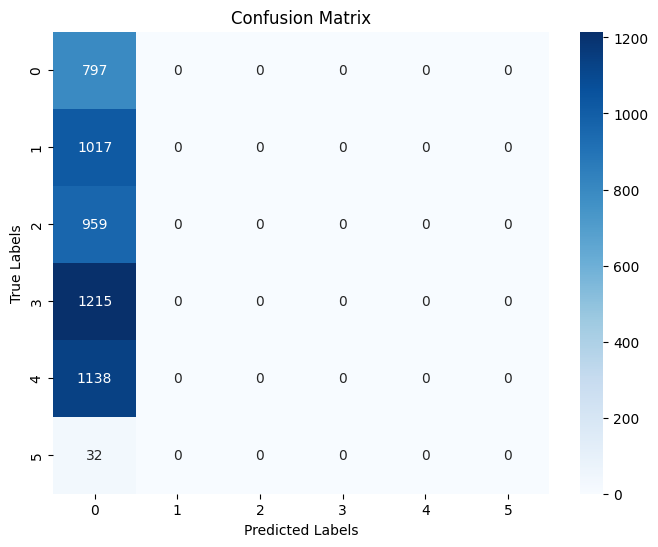

In [60]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sn.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()